# Logistic regression (October 29th, 2024)

## Titanic survivor prediction

### Download the dataset

In [ ]:
!gdown -cq 1SFWQ7Zi83Gff-RVrlHj0z4Llm1Nq4BBA

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Read the dataset

In [ ]:
dataset_path = 'titanic_modified_dataset.csv'
df = pd.read_csv(dataset_path,
                 index_col='PassengerId')

In [ ]:
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Survived
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,0
2,1,1,38.0,1,0,71.2833,1,1,1
3,3,1,26.0,0,0,7.9250,0,2,1
4,1,1,35.0,1,0,53.1000,0,1,1
5,3,0,35.0,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...
887,2,0,27.0,0,0,13.0000,0,5,0
888,1,1,19.0,0,0,30.0000,0,2,1
889,3,1,28.0,1,2,23.4500,0,2,0


In [ ]:
df.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
Survived    0
dtype: int64

### Divide the dataset into `X`, `y` variables

In [ ]:
dataset_arr = df.to_numpy().astype(np.float64)
X, y = dataset_arr[:, :-1], dataset_arr[:, -1]

In [ ]:
X.shape, y.shape

((891, 8), (891,))

### Add `bias` column to `X`

In [ ]:
intercept = np.ones((X.shape[0], 1))
X_b = np.concatenate(
    (intercept, X),
    axis=1
)

### Divide `train`, `val` and `test` sets

In [ ]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X_b, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

### Standardize the sets

In [ ]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

### Implement functions

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat

In [ ]:
predict(X=np.array([[22.3, -1.5, 1.1, 1]]),
        theta=np.array([0.1, -0.15, 0.3, -0.2]))

array([0.92988994])

In [ ]:
def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (
        -y*np.log(y_hat) - (1-y)*np.log(1-y_hat)
    ).mean()

In [ ]:
compute_loss(y=np.array([1, 0, 0, 1]), y_hat=np.array([0.8, 0.75, 0.3, 0.95]))

0.5043515376900958

In [ ]:
def compute_gradient(X, y, y_hat):
    return np.dot(
        X.T, (y_hat - y)
    ) / y.size

In [ ]:
compute_gradient(
    X=np.array([[1, 2], [2, 1], [1, 1], [2, 2]]),
    y=np.array([0, 1, 0, 1]),
    y_hat=np.array([0.25, 0.75, 0.4, 0.8]))

array([-0.0625,  0.0625])

In [ ]:
compute_gradient(
    X=np.array([[1, 3], [2, 1], [3, 2], [1, 2]]),
    y=np.array([1, 0, 1, 1]),
    y_hat=np.array([0.7, 0.4, 0.6, 0.85]))

array([-0.2125, -0.4   ])

In [ ]:
def update_theta(theta, gradient, lr):
    return theta - lr * gradient

In [ ]:
def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [ ]:
# def compute_accuracy(y_true, y_pred):
#     y_pred_rounded = np.round(y_pred)
#     accuracy = np.mean(y_true == y_pred_rounded)

#     return accuracy


# compute_accuracy(y_true=np.array([1, 0, 1, 1]),
#                  y_pred=np.array([0.85, 0.35, 0.9, 0.75]))

1.0

### Define and initialize hyperparameters

In [ ]:
lr = 0.01
epochs = 100
batch_size = 16

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

### Train the model

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(
        train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.703	Validation loss: 0.599

EPOCH 2:	Training loss: 0.670	Validation loss: 0.582

EPOCH 3:	Training loss: 0.640	Validation loss: 0.567

EPOCH 4:	Training loss: 0.614	Validation loss: 0.555

EPOCH 5:	Training loss: 0.592	Validation loss: 0.544

EPOCH 6:	Training loss: 0.572	Validation loss: 0.535

EPOCH 7:	Training loss: 0.554	Validation loss: 0.528

EPOCH 8:	Training loss: 0.539	Validation loss: 0.522

EPOCH 9:	Training loss: 0.526	Validation loss: 0.517

EPOCH 10:	Training loss: 0.514	Validation loss: 0.513

EPOCH 11:	Training loss: 0.504	Validation loss: 0.509

EPOCH 12:	Training loss: 0.495	Validation loss: 0.507

EPOCH 13:	Training loss: 0.487	Validation loss: 0.505

EPOCH 14:	Training loss: 0.480	Validation loss: 0.503

EPOCH 15:	Training loss: 0.474	Validation loss: 0.502

EPOCH 16:	Training loss: 0.468	Validation loss: 0.501

EPOCH 17:	Training loss: 0.463	Validation loss: 0.500

EPOCH 18:	Training loss: 0.459	Validation loss: 0.500

EPOCH 19:	Training

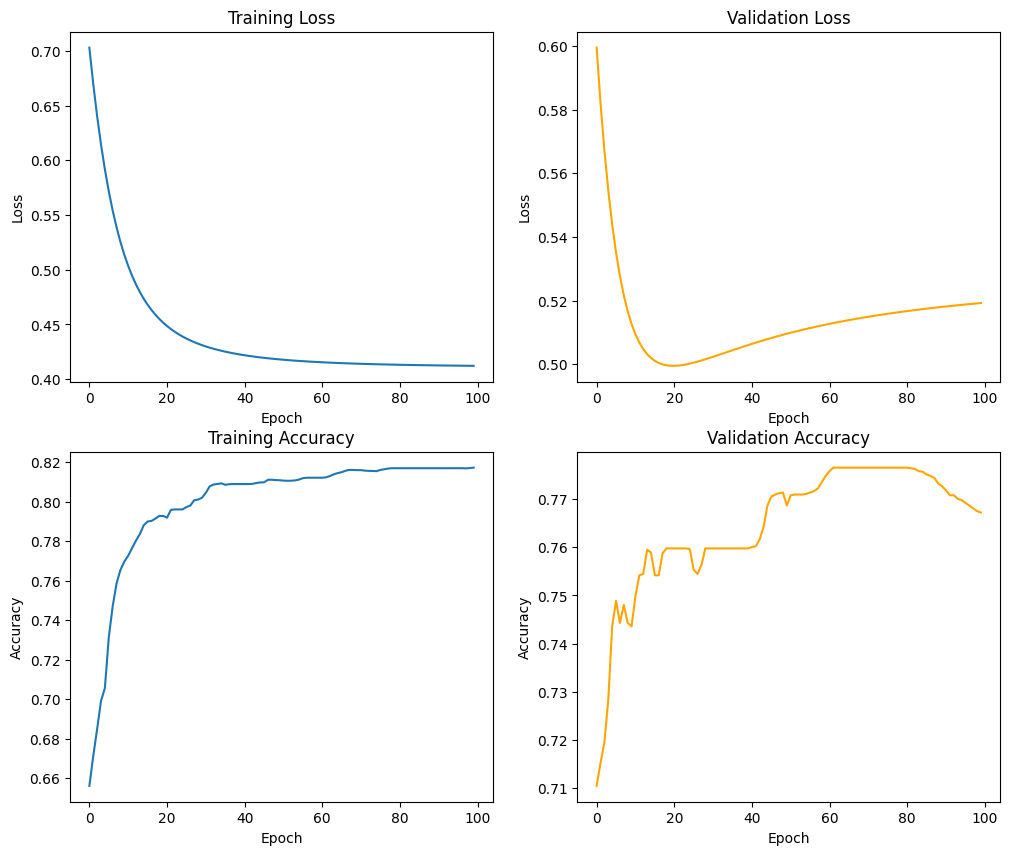

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses,  'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs,  'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluate the model

In [ ]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy: {val_set_acc:.2f}')
print(f'Accuracy: {test_set_acc:.2f}')

Evaluation on validation and test set:
Accuracy: 0.77
Accuracy: 0.78


## Twitter Sentiment Analysis

### Download the dataset

In [ ]:
!gdown -cq 1dANzxlEjeCEbveFOWWqzSG-niVx-vCgK

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib. pyplot as plt

from sklearn. model_selection import train_test_split
from sklearn. preprocessing import StandardScaler
from nltk. tokenize import TweetTokenizer
from collections import defaultdict

### Read the dataset

In [ ]:
dataset_path = 'sentiment_analysis.csv'
df = pd. read_csv(
    dataset_path,
    index_col='id'
)

In [ ]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


### Preprocess the dataset

In [ ]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https ?:\/\/.*[\r\n]*', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [ ]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df. iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

In [ ]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X

In [ ]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
X[:5]

array([[1.000e+00, 1.400e+01, 2.000e+00],
       [1.000e+00, 4.294e+03, 2.794e+03],
       [1.000e+00, 5.425e+03, 1.440e+03],
       [1.000e+00, 6.679e+03, 3.169e+03],
       [1.000e+00, 7.365e+03, 6.269e+03]])

In [ ]:
X.shape, y.shape

((7920, 3), (7920,))

### Split `train`, `val` and `test` sets

In [ ]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

### Standardize the sets

In [ ]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

### Implemnent functions

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
    y_hat = np.clip(
        y_hat, 1e-7, 1 - 1e-7
    )

    return(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat

def compute_gradient(X, y, y_hat):
    return np.dot(
        X.T, (y_hat - y)
    ) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat==y).mean()

    return acc

### Initialize hyperparameters

In [ ]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

### Train the model

In [ ]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(
        train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(
        f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.710	Validation loss: 0.705

EPOCH 2:	Training loss: 0.664	Validation loss: 0.659

EPOCH 3:	Training loss: 0.626	Validation loss: 0.622

EPOCH 4:	Training loss: 0.595	Validation loss: 0.591

EPOCH 5:	Training loss: 0.570	Validation loss: 0.566

EPOCH 6:	Training loss: 0.548	Validation loss: 0.545

EPOCH 7:	Training loss: 0.531	Validation loss: 0.527

EPOCH 8:	Training loss: 0.516	Validation loss: 0.512

EPOCH 9:	Training loss: 0.503	Validation loss: 0.500

EPOCH 10:	Training loss: 0.492	Validation loss: 0.489

EPOCH 11:	Training loss: 0.483	Validation loss: 0.480

EPOCH 12:	Training loss: 0.475	Validation loss: 0.472

EPOCH 13:	Training loss: 0.468	Validation loss: 0.465

EPOCH 14:	Training loss: 0.462	Validation loss: 0.459

EPOCH 15:	Training loss: 0.457	Validation loss: 0.454

EPOCH 16:	Training loss: 0.452	Validation loss: 0.449

EPOCH 17:	Training loss: 0.448	Validation loss: 0.445

EPOCH 18:	Training loss: 0.444	Validation loss: 0.441

EPOCH 19:	Training

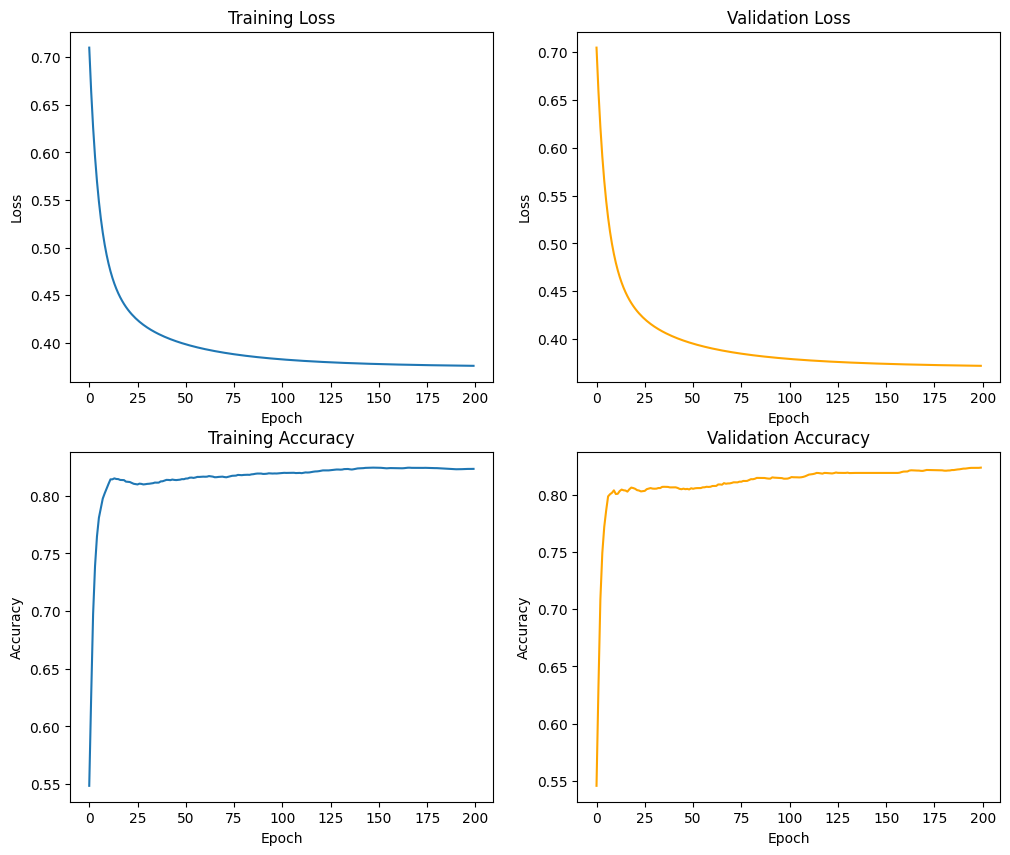

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses,  'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs,  'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

### Evaluate the model

In [ ]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy: {val_set_acc:.2f}')
print(f'Accuracy: {test_set_acc:.2f}')

Evaluation on validation and test set:
Accuracy: 0.82
Accuracy: 0.84
